# Current Limitations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
class LimitationThemeExtractor:
    def __init__(self):
        # Standard English stopwords
        self.stop_words = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
            'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
            'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
            'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
            'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
            'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
            'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
            'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
            'with', 'through', 'during', 'before', 'after', 'above', 'below',
            'up', 'down', 'out', 'off', 'on', 'over', 'under', 'again', 'further',
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
            'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
            'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
            's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'could', 'would'
        }
        
        # Domain-specific stopwords
        self.domain_stopwords = {
            'study', 'model', 'paper', 'research', 'analysis', 'approach',
            'method', 'framework', 'work', 'agent', 'based', 'modeling',
            'finance', 'financial', 'sustainable', 'sustainability', 'limitation',
            'limited', 'constraints', 'constraint', 'challenge', 'challenges'
        }
        self.stop_words.update(self.domain_stopwords)

        # Limitation categories with keywords refined from paper analysis
        self.limitation_categories = {
    'Data Quality & Availability': [
        'data', 'dataset', 'sample', 'limited data', 'data quality',
        'data availability', 'missing data', 'incomplete data', 
        'synthetic data', 'real world data', 'empirical data',
        'sample size', 'small sample', 'insufficient data',
        'lack of data', 'data limitations', 'dataset size',
        'quality of data', 'data source', 'data collection',
        'report quality', 'data trends', 'data constraints',
        'massive datasets', 'limited available data', '2012 financial data',
        'empirical microdata calibration', 'selection bias',
        'limited empirical case depth'
    ],
    'Model Validation & Verification': [
        'validation', 'verification', 'calibration', 'testing',
        'validated', 'verified', 'calibrated', 'benchmark',
        'ground truth', 'empirical validation', 'model validation',
        'validate', 'verify', 'test', 'testing', 'accuracy',
        'performance evaluation', 'model testing', 'cross validation',
        'real-world validation', 'out-of-sample validation',
        'calibration specific', 'calibration parameters',
        'validation challenges', 'lacks comparison'
    ],
    'Computational & Scalability': [
        'computational', 'scalability', 'complexity', 'performance',
        'runtime', 'memory', 'processing', 'scale', 'large scale',
        'computational cost', 'efficiency', 'computing', 'computation',
        'computational time', 'processing power', 'system resources',
        'computational resources', 'scalable', 'scaling',
        'computational complexity', 'computational demands',
        'high early-stage costs', 'real-time implementation',
        'large networks', 'time-resource bias'
    ],
    'Generalizability & External Validity': [
        'generalization', 'generalizable', 'external validity',
        'transferability', 'robustness', 'specific context',
        'limited scope', 'narrow scope', 'case study', 'generalize',
        'applicability', 'transferable', 'context specific',
        'domain specific', 'limited applicability', 'scope',
        'broader applicability', 'external validation',
        'dataset scope', 'different contexts', 'case-study based',
        'limited to two districts', 'limited to uk electricity market parameters',
        'limited to specific market conditions', 'limited to interbank liability networks',
        'excludes other financial networks', 'limited to swedish context',
        'limited to specific microfinance context', 'limited to palm oil',
        'specific industry context', 'geographic generalizability',
        'sectoral generalizability', 'indonesian context only', 'uk-specific',
        'single supply chain case study', 'broader sustainability impact assessment',
        'limited to three broad financing methods', 'project-specific characteristics not considered',
        'coefficients cannot be applied worldwide', 'universal solution',
        'limited to solar farms', 'focus on climate and financial regulation only',
        'limited to upstream supply chain only'
    ],
    'Behavioral Assumptions & Agent Design': [
        'behavioral', 'behavior', 'assumption', 'assumptions',
        'agent behavior', 'decision making', 'rationality',
        'bounded rationality', 'heterogeneity', 'agent design',
        'behavioral assumptions', 'agent interactions', 'agent rules',
        'behavioral patterns', 'decision rules', 'cognitive',
        'psychological', 'heterogeneous agents',
        'complex model assumptions', 'simplified developer decision-making',
        'random network assumption unrealistic', 'homogeneous bank assumption',
        'no learning mechanisms', 'assumes constant feed-in tariffs',
        'uniform user distribution', 'simplified agent behaviors',
        'uniform distribution assumptions', 'limited to single ebin and bank agents',
        'conservative price assumptions', 'model assumes defaults occur only at loan maturity',
        'simplified recovery assumptions', 'modeling assumptions',
        'simplified agent rules', 'uniform wealth distribution assumption',
        'excludes insolvent clients', 'technological progress assumed fixed',
        'housing behavior modeled simply', 'simplified agent interactions',
        'heterogeneous interests'
    ],
    'Policy & Implementation': [
        'policy', 'regulation', 'regulatory', 'governance',
        'implementation', 'practical', 'real world application',
        'policy makers', 'stakeholders', 'policy implications',
        'regulatory framework', 'policy intervention', 'practical implementation',
        'real world implementation', 'policy design', 'institutional',
        'macroprudential regulation', 'real-world policy outcomes',
        'global implementation', 'avoid free-riding', 'no implementation',
        'lack of uniform product standards', 'environmental taxonomy link',
        'simplifications on government role', 'flat tax system',
        'fixed social security parameters', 'full implementation'
    ],
    'Methodological & Technical': [
        'methodology', 'methodological', 'approach limitation',
        'technique', 'parameter', 'sensitivity', 'uncertainty',
        'model structure', 'technical', 'methodological issues',
        'technical limitations', 'parameter estimation', 'model specification',
        'algorithmic', 'simulation', 'modeling approach',
        'overfitting', 'static damage functions',
        'financial sector not fully modeled', 'simplified representation',
        'conceptual', 'complexity of real-world systems', 'theoretical',
        'does not implement specific abm model', 'excludes biophysical environmental impact analysis',
        'simplified fossil fuel/oil prices', 'simplified demand representation',
        'deterministic simulation', 'without stochastic processes',
        'no risk consideration', 'no taxation effects included',
        'theoretical parameters', 'tool not specified', 'empirical model',
        'common platforms', 'relies on cited studies', 'dice damage functions',
        'prototype phase', 'simplified banking model', 'excludes taxation effects',
        'theoretical framework', 'conceptual model', 'proof of concept',
        'alternative financing sources', 'simplified financial sector',
        'interdisciplinary expertise', 'excludes political/social factors',
        'open-loop framework', 'feedback effects', 'simplified environmental and economic processes',
        'no consideration of environmental externalities', 'financing-transition modeling',
        'disaster integration', 'classification subjectivity', 'emergent properties not fully explored',
        'only one bank type modeled', 'no endogenous interest rate changes',
        'theoretical environmental algorithms', 'simplified representation of environmental processes',
        'banking sector modeled simply', 'results sensitive', 'conventional agreement',
        'fundamental price estimation'
    ],
    'Temporal & Dynamic Aspects': [
        'temporal', 'time', 'dynamic', 'longitudinal', 'long term',
        'short term', 'time series', 'evolution', 'adaptation',
        'time horizon', 'temporal dynamics', 'time period',
        'dynamic behavior', 'time scale', 'temporal resolution',
        'historical data', 'time dependent',
        'short crisis periods', 'single time-step per year',
        'short-term storage modeling'
    ]
}
      
    def preprocess_text(self, text):
        """Text preprocessing"""
        if pd.isna(text) or text.strip() == '':
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits, keep spaces and letters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Split into words (simple tokenization)
        words = text.split()
        
        # Remove stopwords and short words
        words = [word for word in words 
                if word not in self.stop_words and len(word) > 2]
        
        return ' '.join(words)
    
    def extract_keywords_tfidf(self, texts, max_features=100):
        """Extract important keywords using term frequency inverse document frequency (TF-IDF)"""
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        # Filter out empty texts
        non_empty_texts = [text for text in processed_texts if text.strip()]
        
        if len(non_empty_texts) < 2:
            print("Warning: Not enough text data for TF-IDF analysis")
            return []
        
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 3),
            min_df=1,  # Reduced min_df for smaller datasets
            max_df=0.9
        )
        
        try:
            tfidf_matrix = vectorizer.fit_transform(non_empty_texts)
            feature_names = vectorizer.get_feature_names_out()
            
            # Get average TF-IDF scores
            mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
            keyword_scores = list(zip(feature_names, mean_scores))
            keyword_scores.sort(key=lambda x: x[1], reverse=True)
            
            return keyword_scores
        except Exception as e:
            print(f"TF-IDF analysis failed: {e}")
            return []
    
    def categorize_limitations_keyword_based(self, texts):
        """Categorize limitations using keyword matching"""
        categorized_results = []
        
        for idx, text in enumerate(texts):
            if pd.isna(text) or text.strip() == '':
                categorized_results.append({})
                continue
                
            text_lower = text.lower()
            doc_categories = defaultdict(list)
            
            # Check each category
            for category, keywords in self.limitation_categories.items():
                matches = []
                match_positions = []
                
                for keyword in keywords:
                    # Check for exact phrase matches
                    if keyword in text_lower:
                        matches.append(keyword)
                        match_positions.extend([m.start() for m in re.finditer(re.escape(keyword), text_lower)])
                
                if matches:
                    # Calculate relevance score
                    score = len(matches) + len(set(matches)) * 0.5  # Bonus for unique matches
                    
                    doc_categories[category] = {
                        'matches': list(set(matches)),  # Remove duplicates
                        'match_count': len(matches),
                        'unique_matches': len(set(matches)),
                        'score': score,
                        'text_snippet': self.extract_relevant_snippet(text, matches, match_positions)
                    }
            
            categorized_results.append(dict(doc_categories))
        
        return categorized_results
    
    def extract_relevant_snippet(self, text, keywords, positions=None, context_length=150):
        """Extract text snippet around matched keywords"""
        if not keywords:
            return text[:200] + "..." if len(text) > 200 else text
            
        text_lower = text.lower()
        best_snippet = ""
        max_matches = 0
        
        # Try to find the section with the most keyword matches
        for keyword in keywords[:3]:  # Check top 3 matches
            pos = text_lower.find(keyword)
            if pos != -1:
                start = max(0, pos - context_length//2)
                end = min(len(text), pos + len(keyword) + context_length//2)
                snippet = text[start:end]
                
                # Count how many keywords appear in this snippet
                matches_in_snippet = sum(1 for kw in keywords if kw in snippet.lower())
                
                if matches_in_snippet > max_matches:
                    max_matches = matches_in_snippet
                    best_snippet = f"...{snippet}..." if start > 0 or end < len(text) else snippet
        
        return best_snippet if best_snippet else text[:200] + "..."
    
    def create_limitation_distribution(self, categorized_results):
        """Create distribution summary of limitation categories"""
        category_counts = defaultdict(int)
        category_details = defaultdict(list)
        category_scores = defaultdict(float)
        
        for idx, doc_cats in enumerate(categorized_results):
            for category, details in doc_cats.items():
                category_counts[category] += 1
                category_scores[category] += details['score']
                category_details[category].append({
                    'paper_idx': idx,
                    'score': details['score'],
                    'match_count': details['match_count'],
                    'unique_matches': details['unique_matches'],
                    'matches': details['matches'],
                    'snippet': details['text_snippet']
                })
        
        # Sort by frequency, then by average score
        sorted_categories = sorted(
            category_counts.items(), 
            key=lambda x: (x[1], category_scores[x[0]]/max(1, x[1])), 
            reverse=True
        )
        
        return sorted_categories, dict(category_details), dict(category_scores)
    
    def plot_limitation_distribution(self, sorted_categories, total_papers, save_path=None):
        """Create visualization of limitation distribution"""
        if not sorted_categories:
            print("No limitation categories found.")
            return None
        
        categories, counts = zip(*sorted_categories)
        percentages = [count/total_papers*100 for count in counts]
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Colors
        colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
        
        # Horizontal bar chart
        y_pos = np.arange(len(categories))
        bars = ax1.barh(y_pos, counts, color=colors, alpha=0.8)
        
        # Customize horizontal bar chart
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels([cat.replace(' & ', ' &\n') for cat in categories], fontsize=11)
        ax1.set_xlabel('Number of Studies', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.set_axisbelow(True)
        
        # Add count and percentage labels on bars
        for i, (bar, count) in enumerate(zip(bars, counts)):
            ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                    f'{count}', va='center', ha='left', fontsize=10, fontweight='bold')
        
        # Set x-axis limit with some padding
        ax1.set_xlim(0, max(counts) * 1.25)
        
        # Pie chart
        wedges, texts, autotexts = ax2.pie(counts, colors=colors, autopct='%1.1f%%', 
                                          startangle=90, textprops={'fontsize': 9})
        
        # Manage pie chart text
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        # Add legend for pie chart
        legend_labels = [f"{cat}\n({count} studies)" for cat, count in sorted_categories]
        ax2.legend(wedges, legend_labels, title="Limitation Categories", 
                  loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
                  fontsize=12, title_fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Figure saved to: {save_path}")
        
        plt.show()
        return fig
    
    def generate_summary_report(self, sorted_categories, category_details, category_scores, total_papers, categorized_results_raw):
        """Generate a comprehensive summary report"""
        print("="*80)
        print("AUTOMATED LIMITATION THEME EXTRACTION REPORT")
        print("="*80)
        print(f"Total papers analyzed: {total_papers}")
        # Count unique papers that had at least one category assigned
        papers_successfully_categorized = len([d for d in categorized_results_raw if d])
        print(f"Papers with limitation data (successfully categorized): {papers_successfully_categorized}")
        
        print(f"Limitation categories identified: {len(sorted_categories)}")
        
        if not sorted_categories:
            print("\nNo limitation categories found in the data.")
            return {}
        
        total_categorized_assignments = sum(count for _, count in sorted_categories)
        coverage = total_categorized_assignments / total_papers * 100 if total_papers > 0 else 0
        
        
        print(f"Overall categorization coverage: {coverage:.1f}%")
        print()
        
        print("TOP LIMITATION CATEGORIES:")
        print("-" * 50)
        
        for i, (category, count) in enumerate(sorted_categories, 1):
            percentage = count/total_papers*100
            avg_score = category_scores[category]/count if count > 0 else 0
            
            print(f"{i}. {category}")
            print(f"   Studies: {count} ({percentage:.1f}% of all papers)")
            print(f"   Average relevance score: {avg_score:.2f}")
            
            # Show most common keywords
            all_matches = []
            for detail in category_details[category]:
                all_matches.extend(detail['matches'])
            
            if all_matches:
                top_keywords = Counter(all_matches).most_common(5)
                print(f"   Most common keywords: {', '.join([f'{kw}({cnt})' for kw, cnt in top_keywords])}")
            
            # Show few examples
            examples = sorted(category_details[category], 
                            key=lambda x: x['score'], reverse=True)[:2]
            for j, example in enumerate(examples, 1):
                snippet = example['snippet']
                if len(snippet) > 120:
                    snippet = snippet[:120] + "..."
                print(f"   Example {j}: {snippet}")
            print()
        
        # Additional statistics
        print("ADDITIONAL STATISTICS:")
        print("-" * 30)
        print(f"Average categories per paper: {total_categorized_assignments/total_papers:.2f}")

        multi_limitation_papers = sum(1 for d in categorized_results_raw if len(d) > 1)
        print(f"Papers with multiple limitation types: {multi_limitation_papers}")


        return {
            'total_papers': total_papers,
            'papers_with_limitations': papers_successfully_categorized,
            'categories_found': len(sorted_categories),
            'distribution': dict(sorted_categories),
            'coverage_percentage': coverage,
            'avg_categories_per_paper': total_categorized_assignments/total_papers if total_papers > 0 else 0
        }




In [3]:
def analyze_limitations(df, limitation_column='Limitations', save_figure_path=None):
    """Main function to analyze limitations from dataframe"""
    
    print("Starting automated limitation theme extraction...")
    print("=" * 60)
    
    # Initialize extractor
    extractor = LimitationThemeExtractor()
    
    # Extract limitation texts
    if limitation_column not in df.columns:
        print(f"Error: Column '{limitation_column}' not found in dataframe.")
        print(f"Available columns: {list(df.columns)}")
        return None
    
    limitation_texts = df[limitation_column].fillna('').tolist()
    total_papers = len(df)
    papers_with_limitations = len([text for text in limitation_texts if str(text).strip() and str(text) != 'nan'])
    
    print(f"Total papers in dataset: {total_papers}")
    print(f"Papers with limitation data: {papers_with_limitations}")
    
    if papers_with_limitations == 0:
        print("No limitation data found in the dataset.")
        return None
    
    # Extract keywords using TF-IDF for transparency
    print(f"\nExtracting key terms using TF-IDF...")
    keywords = extractor.extract_keywords_tfidf(limitation_texts, max_features=30)
    
    if keywords:
        print("Top 10 limitation-related terms:")
        for term, score in keywords[:10]:
            print(f"  - {term}: {score:.3f}")
    
    # Categorize limitations
    print(f"\nCategorizing limitations using keyword matching...")
    categorized_results = extractor.categorize_limitations_keyword_based(limitation_texts) 
    
    
    # Create distribution
    sorted_categories, category_details, category_scores = extractor.create_limitation_distribution(categorized_results)
    
    if not sorted_categories:
        print("No limitation categories were identified.")
        return None
    
    # Generate visualizations
    print(f"\nGenerating visualizations...")
    fig = extractor.plot_limitation_distribution(sorted_categories, total_papers, save_figure_path)
    
    # Generate summary report
    summary = extractor.generate_summary_report(sorted_categories, category_details, category_scores, total_papers, categorized_results)
    
    # Create results dataframe for further analysis
    results_df = pd.DataFrame([
        {
            'Category': cat, 
            'Count': count, 
            'Percentage': count/total_papers*100,
            'Avg_Score': category_scores[cat]/count if count > 0 else 0
        }
        for cat, count in sorted_categories
    ])
    
    print(f"\nAnalysis complete! Results summary:")
    print(results_df.to_string(index=False))
    
    return {
        'results_df': results_df,
        'categorized_results': categorized_results,
        'category_details': category_details,
        'summary': summary,
        'figure': fig,
        'extractor': extractor,
        'keywords': keywords
    }


Starting automated limitation theme extraction...
Total papers in dataset: 45
Papers with limitation data: 45

Extracting key terms using TF-IDF...
Top 10 limitation-related terms:
  - validation: 0.113
  - specific: 0.110
  - simplified: 0.108
  - calibration: 0.083
  - empirical: 0.082
  - environmental: 0.074
  - implementation: 0.072
  - need: 0.063
  - uniform: 0.062
  - data: 0.061

Categorizing limitations using keyword matching...

Generating visualizations...
Figure saved to: limitations_distribution.png


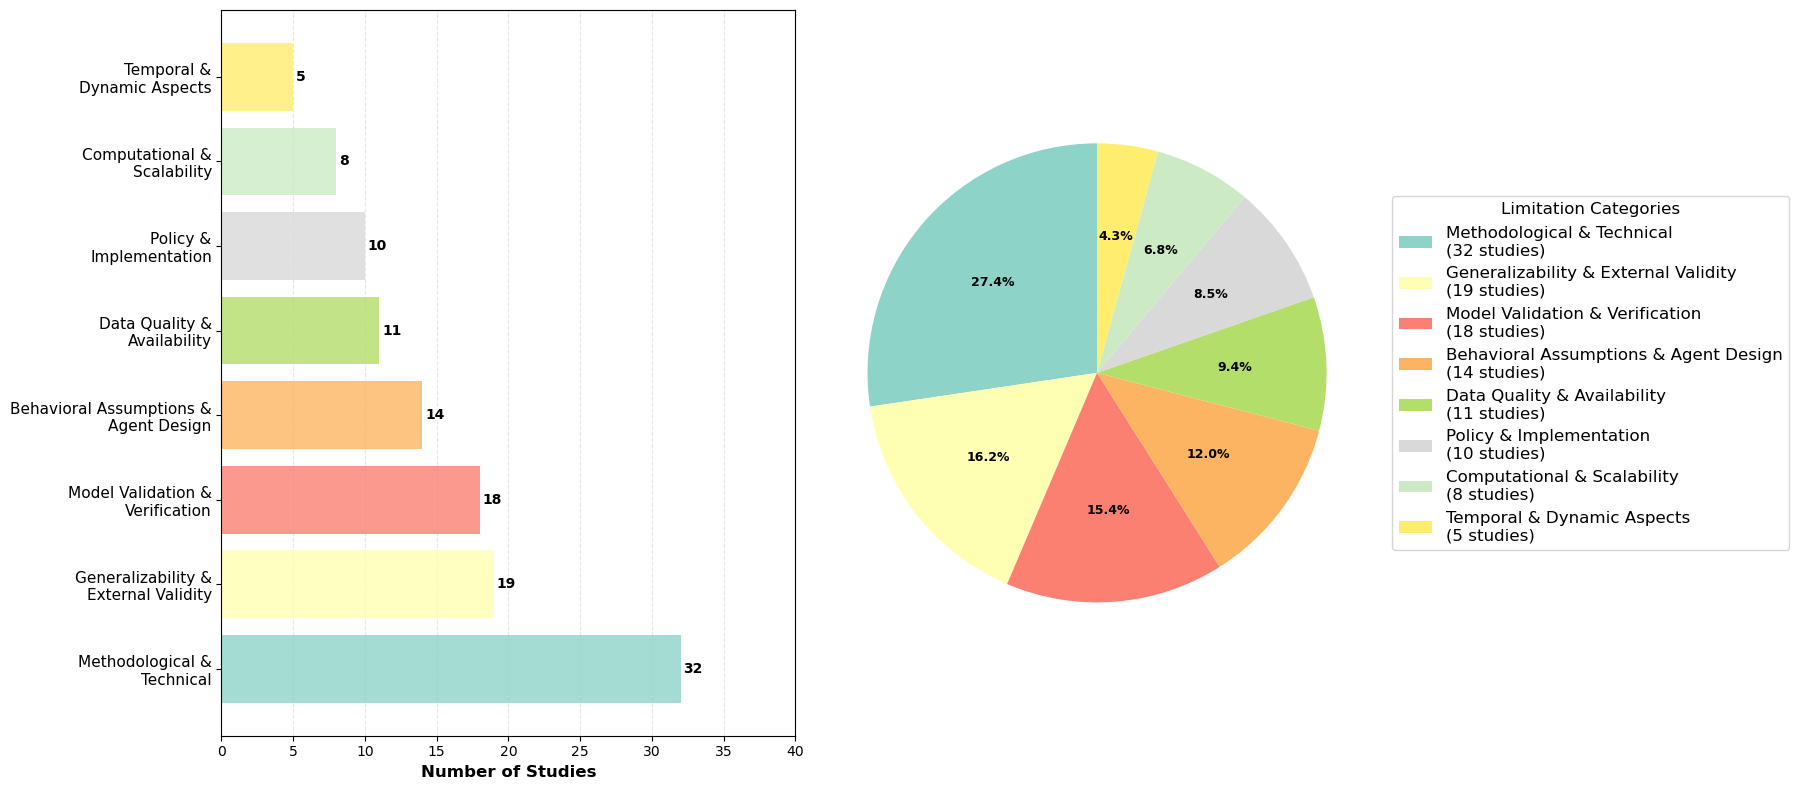

AUTOMATED LIMITATION THEME EXTRACTION REPORT
Total papers analyzed: 45
Papers with limitation data (successfully categorized): 45
Limitation categories identified: 8
Overall categorization coverage: 260.0%

TOP LIMITATION CATEGORIES:
--------------------------------------------------
1. Methodological & Technical
   Studies: 32 (71.1% of all papers)
   Average relevance score: 3.00
   Most common keywords: parameter(6), theoretical(5), conceptual(3), conceptual model(2), simplified representation(2)
   Example 1: ...Conceptual model with theoretical environmental algorithms; coefficients cannot be ap...
   Example 2: ...Deterministic simulation without stochastic processes; Uniform distribution assumptions; Limited to...

2. Generalizability & External Validity
   Studies: 19 (42.2% of all papers)
   Average relevance score: 2.37
   Most common keywords: external validity(2), case study(2), limited to swedish context(1), limited to specific market conditions(1), limited to two district

In [4]:
# Loading data
df = pd.read_excel('Coded_data.xlsx')

# Run analysis with figure saving
results = analyze_limitations(df, 
                                   limitation_column='Limitations',
                                   save_figure_path='limitations_distribution.png')

if results:
    # Access results
    print("\\nFinal Results DataFrame:")
    print(results['results_df'])
    
    # Save results to CSV
    results['results_df'].to_csv('limitation_categories_results.csv', index=False)
    print("Results saved to limitation_categories_results.csv")


In [5]:
!pip install plotly WordCloud

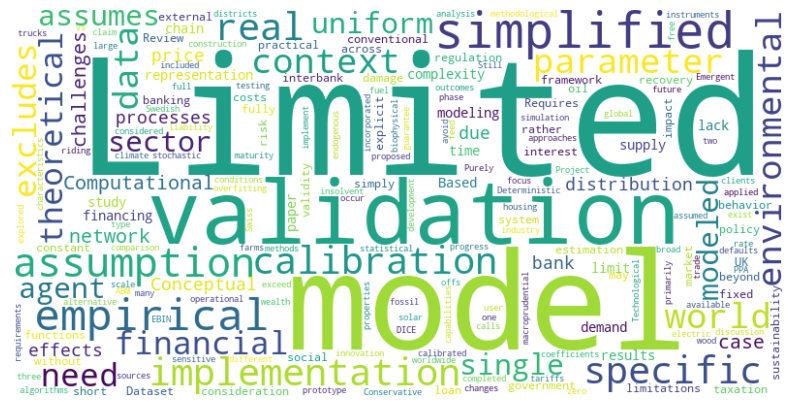

In [6]:
from wordcloud import WordCloud

# Drop NaN values and combine all text into one string
text = " ".join(df['Limitations'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    collocations=False  # prevents joining common phrases like 'real world'
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title("Word Cloud of Study Limitations", fontsize=16)
plt.savefig("wordcloud_limitation.png", dpi=300)
plt.show()


## Geographic and contextual limitations

In [7]:
df1=df.copy()

In [8]:
#import plotly.io as pio
#pio.renderers.default = "notebook" 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.subplots as sp
# Ensure plotly renders in Jupyter
pio.renderers.default = "notebook_connected"

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Aggregate study counts by country 
region_counts = df1["Country/Region"].value_counts().reset_index()
region_counts.columns = ["Country/Region", "Count"]

# Function for row coloring
def get_cell_colors(country):
    return "lightblue" if country == "Global" else "white"

# Totals
highlight_mask = region_counts["Country/Region"].isin(["Global"])
total_highlighted = region_counts.loc[highlight_mask, "Count"].sum()
total_other = region_counts.loc[~highlight_mask, "Count"].sum()
grand_total = region_counts["Count"].sum()

totals_rows = [
    {"Country/Region": "Total Highlighted", "Count": total_highlighted},
    {"Country/Region": "Total Other", "Count": total_other},
    {"Country/Region": "Grand Total", "Count": grand_total},
]
totals_df = pd.DataFrame(totals_rows)

region_counts_with_totals = pd.concat([region_counts, totals_df], ignore_index=True)

# Extended colors for table rows
extended_colors = [
    "lightgrey" if c in ["Total Highlighted", "Total Other", "Grand Total"] else get_cell_colors(c)
    for c in region_counts_with_totals["Country/Region"]
]

# Table
fig_table = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["<b>Country/Region</b>", "<b>Number of Studies</b>"],
                fill_color="lightgrey",
                align="left"
            ),
            cells=dict(
                values=[region_counts_with_totals["Country/Region"], region_counts_with_totals["Count"]],
                fill_color=[extended_colors, extended_colors],
                align="left"
            )
        )
    ]
)

# Show the table
fig_table.update_layout(height=600, showlegend=False)
fig_table.show()

In [10]:
# Map ambiguous labels to proper countries or drop them
replace_map = {
    "Global": None,   # drop, doesn't map to a single country. Global here means more than one country
   # "Europe": None,   # drop 
}
df2 = df1.copy()
df2["Country/Region"] = df2["Country/Region"].replace(replace_map)


In [11]:
# Aggregate counts by country
region_counts = df2["Country/Region"].value_counts().reset_index()
region_counts.columns = ["Country/Region", "Count"]

# Create choropleth map
fig_map = px.choropleth(
    region_counts,
    locations="Country/Region",
    locationmode="country names",
    color="Count",
    projection="natural earth",
    color_continuous_scale="YlGnBu",
   # title="Studies by Country/Region"
)

# Position the legend
fig_map.update_layout(
    coloraxis_colorbar=dict(
        x=1,  # Position to the right of the map
        y=0.5,   # Center vertically
        len=0.8, # Length of the colorbar
        thickness=30  # Width of the colorbar
    ),
    height=900,  # Adjust height as needed
    showlegend=False
)
# Save figure as html
fig_map.write_html("studies_by_country_map.html")

#display figure
fig_map.show()

## Domain coverage gaps and regulatory alignment challenges

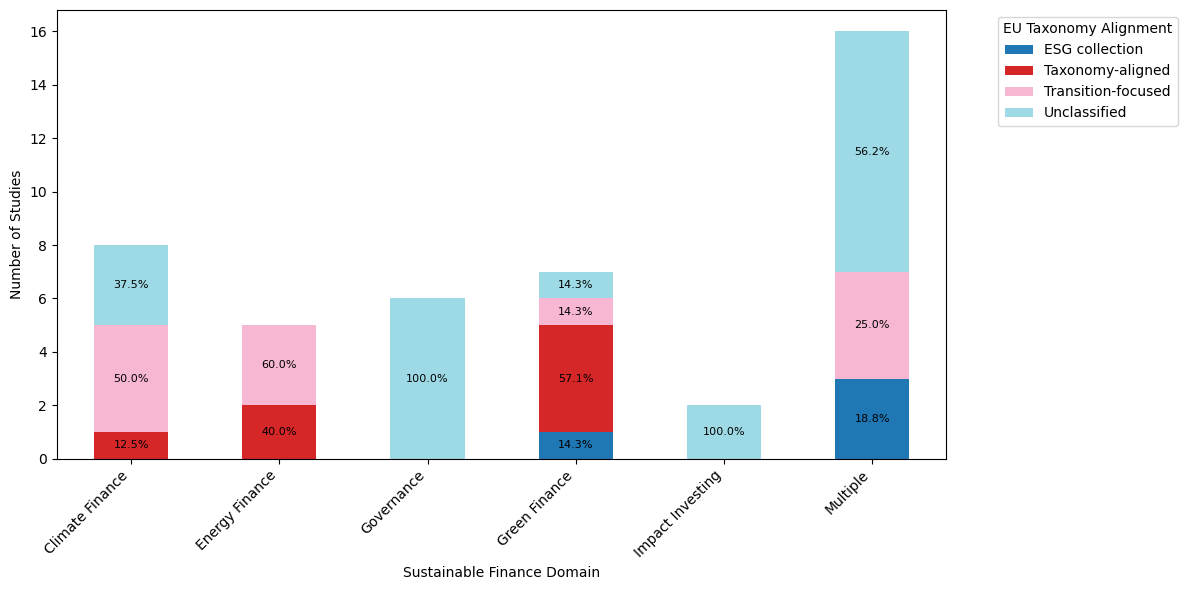

In [12]:
# Cross-tabulate Domain, Taxonomy Alignment 
ct = pd.crosstab(
    df["Sustainable Finance Domain"],
    df["EU Taxonomy Categories-Alignment"]
)

# Normalized percentages for labeling 
ct_norm = ct.div(ct.sum(axis=1), axis=0) * 100

# Plot stacked bar
ax = ct.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="tab20"
)

plt.xlabel("Sustainable Finance Domain")
plt.ylabel("Number of Studies")
plt.xticks(rotation=45, ha="right")
plt.legend(title="EU Taxonomy Alignment", bbox_to_anchor=(1.05, 1), loc="upper left")

#  Add percentage labels inside each bar segment
for i, domain in enumerate(ct.index):
    total = ct.loc[domain].sum()
    cumulative = 0
    for j, cat in enumerate(ct.columns):
        value = ct.loc[domain, cat]
        if value > 0:
            percent = ct_norm.loc[domain, cat]
            ax.text(
                i,                          # x-position (bar index)
                cumulative + value / 2,     # y-position (middle of segment)
                f"{percent:.1f}%",          # label text
                ha="center", va="center", fontsize=8, color="black"
            )
        cumulative += value

plt.tight_layout()
plt.savefig("domain_coverage.png", dpi=300)
plt.show()
